# Determining the point-spread-function from a bead image by averaging
In order to deconvolve a microsocpy image properly, we should determine the point-spread-function (PSF) of the microscope.

See also 
* [PSF destilling by Brian Northan](https://github.com/True-North-Intelligent-Algorithms/tnia-python/blob/main/notebooks/Deconvolution/extract_psf-Haase-beads.ipynb)

In [1]:
import numpy as np
from skimage.io import imread, imsave
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import pandas as pd
import matplotlib.pyplot as plt
from os import path

/home/dell/miniconda3/envs/spt_cle_39/lib/python3.9/site-packages/pytools/persistent_dict.py:63: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


The example image data used here was acquired by Bert Nitzsche and Robert Haase (both MPI-CBG at that time) at the Light Microscopy Facility of MPI-CBG. Just for completeness, the voxel size is 0.022x0.022x0.125 µm^3.

In [2]:
# must convert ome.tif into regular tif first, otherwise has bug
beads_imgpath = [
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view02.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view03.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view04.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view05.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view06.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view07.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view08.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view09.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view10.ome.tif',
#     '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/qdot655_zstack10um_step250nm_Ti2Z_view11.ome.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view02.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view03.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view04.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view05.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view06.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view07.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view08.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view09.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view10.tif',
    # '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view11.tif',
    '/mnt/disk1/WZH-DataCenter/PROCESS-SPT/MPALM_revision1/SMLM2016_challenge/sequence-as-stack-Beads-2D/sequence-as-stack-Beads-2D-Exp.tif'
]

bead_images = []
for img_path in beads_imgpath:
    bead_image = imread(img_path)
    bead_images.append(bead_image)

# Convert the list of arrays to a single 4D numpy array
bead_images = np.array(bead_images)
bead_images.shape


(1, 151, 150, 150)

Our example image shows fluorescent beads, ideally with a diameter smaller than the resolution of the imaging setup. Furthermore, the beads should emit light in the same wavelength as the sample we would like to deconvolve later on. In the following image crop we see four fluorescent beads. It is recommended to image a larger field of view, with at least 25 beads. Also make sure that the beads do not stick to each other and are sparsely distributed.

/home/dell/miniconda3/envs/spt_cle_39/lib/python3.9/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


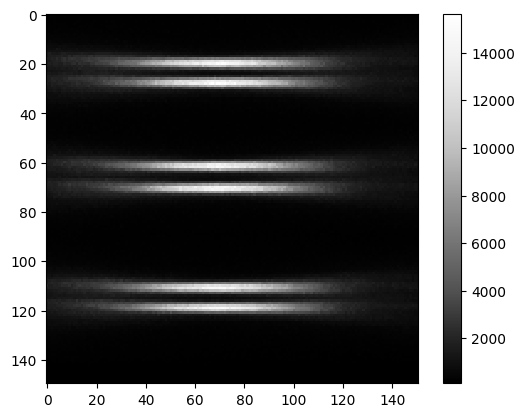

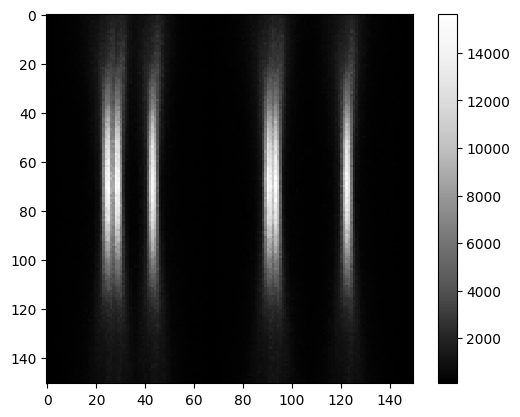

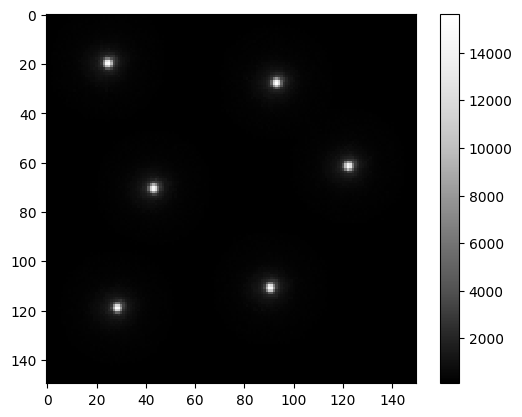

In [3]:
imshow(cle.maximum_x_projection(bead_images[0,]), colorbar=True)
imshow(cle.maximum_y_projection(bead_images[0,]), colorbar=True)
imshow(cle.maximum_z_projection(bead_images[0,]), colorbar=True)

For determining an average PSF, technically we can crop out all the individual beads, align them and then average the images. Therefore, we segment the objects and determine their center of mass.

In [4]:
# ------------- batch mode --------------- #

for iter in range(len(beads_imgpath)):
    # Segment objects
    label_image = cle.voronoi_otsu_labeling(bead_images[iter,])

    # determine center of mass for each object
    stats = cle.statistics_of_labelled_pixels(bead_images[iter,], label_image)

    df = pd.DataFrame(stats)
    df[["mass_center_x", "mass_center_y", "mass_center_z"]]

    ## PSF averaging
    # configure size of future PSF image
    psf_radius = 16
    size = psf_radius * 2 + 1

    # initialize PSF
    single_psf_image = cle.create([size, size, size])
    avg_psf_image = cle.create([size, size, size])

    num_psfs = len(df)
    for index, row in df.iterrows():
        x = row["mass_center_x"]
        y = row["mass_center_y"]
        z = row["mass_center_z"]
        
        print("Bead", index, "at position", x, y, z)
        
        # move PSF in right position in a smaller image
        cle.translate(bead_images[0,], single_psf_image, 
                    translate_x= -x + psf_radius,
                    translate_y= -y + psf_radius,
                    translate_z= -z + psf_radius)

        # # visualize
        # fig, axs = plt.subplots(1,3)    
        # imshow(cle.maximum_x_projection(single_psf_image), plot=axs[0])
        # imshow(cle.maximum_y_projection(single_psf_image), plot=axs[1])
        # imshow(cle.maximum_z_projection(single_psf_image), plot=axs[2])
        
        # average
        avg_psf_image = avg_psf_image + single_psf_image / num_psfs




size: 151
Bead 0 at position 24.67510223388672 19.72089958190918 65.134033203125
Bead 1 at position 28.48023223876953 118.86817932128906 65.21663665771484
Bead 2 at position 43.12558364868164 70.40511322021484 65.28018188476562
Bead 3 at position 90.46227264404297 110.74870300292969 65.16768646240234
Bead 4 at position 93.05615234375 27.59383201599121 65.21595001220703
Bead 5 at position 122.29486083984375 61.52336120605469 65.29669189453125


size: 151


/home/dell/miniconda3/envs/spt_cle_39/lib/python3.9/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


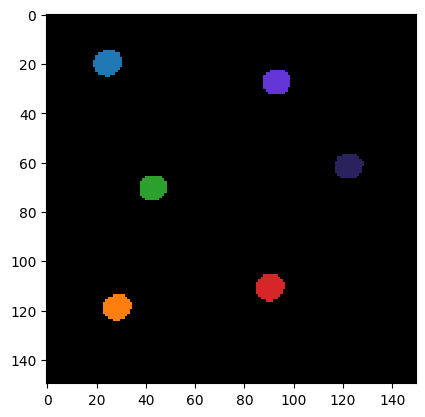

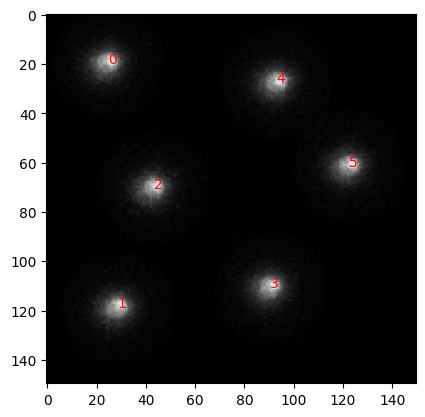

In [5]:
# Segment objects
label_image = cle.voronoi_otsu_labeling(bead_images[0,])
imshow(label_image, labels=True)

# determine center of mass for each object
stats = cle.statistics_of_labelled_pixels(bead_images[0,], label_image)

df = pd.DataFrame(stats)
df[["mass_center_x", "mass_center_y", "mass_center_z"]]

# Convert dataframe to numpy array
centers = df[["mass_center_x", "mass_center_y", "mass_center_z"]].to_numpy()

# Overlay labels on bead_image
fig, ax = plt.subplots()
ax.imshow(bead_images[0,20,:], cmap='gray')
for i, (x, y, z) in enumerate(centers):
    ax.text(x, y, str(i), color='red')  # Assuming mass_center_x corresponds to y and mass_center_y corresponds to x
plt.show()

below are valid beads index for each file based on PSFj, ordered by the file order
[[1,4,5,8]
[0,4]
[1,6,8]
[]
[5]
[0,2,5]
[2,3,4]
[5,6,7]
[0,3,6,8]
[0,1,4,5]]


## PSF averaging
Next, we will iterate over the beads and crop them out by translating them into a smaller PSF image.

Bead 0 at position 24.67510223388672 19.72089958190918 65.134033203125
Bead 1 at position 28.48023223876953 118.86817932128906 65.21663665771484
Bead 2 at position 43.12558364868164 70.40511322021484 65.28018188476562
Bead 3 at position 90.46227264404297 110.74870300292969 65.16768646240234
Bead 4 at position 93.05615234375 27.59383201599121 65.21595001220703
Bead 5 at position 122.29486083984375 61.52336120605469 65.29669189453125


/home/dell/miniconda3/envs/spt_cle_39/lib/python3.9/site-packages/pyclesperanto_prototype/_tier9/_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


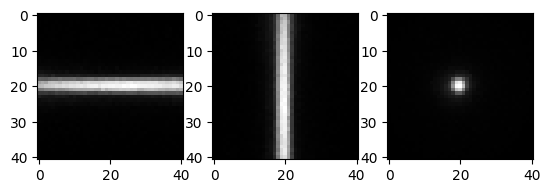

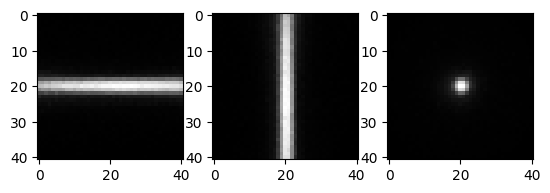

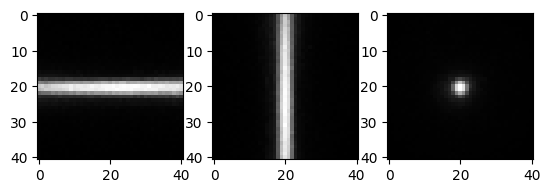

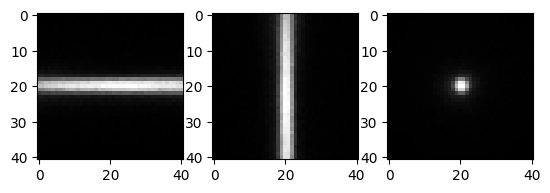

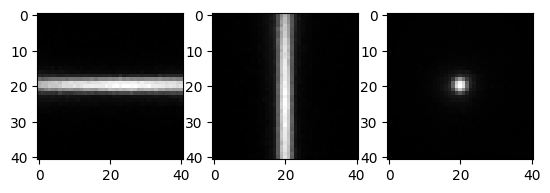

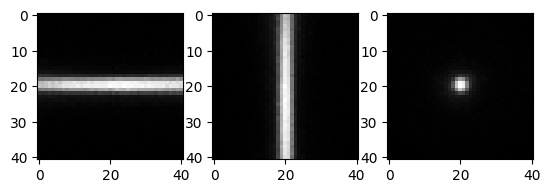

In [6]:
# configure size of future PSF image
psf_radius = 20
size = psf_radius * 2 + 1

# initialize PSF
single_psf_image = cle.create([size, size, size])
avg_psf_image = cle.create([size, size, size])

num_psfs = len(df)
for index, row in df.iterrows():
    x = row["mass_center_x"]
    y = row["mass_center_y"]
    z = row["mass_center_z"]
    
    print("Bead", index, "at position", x, y, z)
    
    # move PSF in right position in a smaller image
    cle.translate(bead_images[0,], single_psf_image, 
                  translate_x= -x + psf_radius,
                  translate_y= -y + psf_radius,
                  translate_z= -z + psf_radius)

    # visualize
    fig, axs = plt.subplots(1,3)    
    imshow(cle.maximum_x_projection(single_psf_image), plot=axs[0])
    imshow(cle.maximum_y_projection(single_psf_image), plot=axs[1])
    imshow(cle.maximum_z_projection(single_psf_image), plot=axs[2])
    
    # average
    avg_psf_image = avg_psf_image + single_psf_image / num_psfs

The average PSF then looks like this:

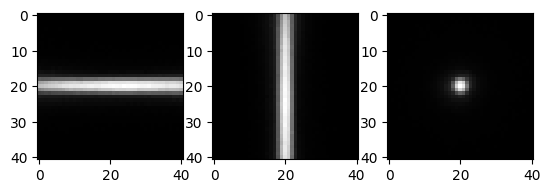

In [8]:
fig, axs = plt.subplots(1,3)    
imshow(cle.maximum_x_projection(avg_psf_image), plot=axs[0])
imshow(cle.maximum_y_projection(avg_psf_image), plot=axs[1])
imshow(cle.maximum_z_projection(avg_psf_image), plot=axs[2])

In [9]:
avg_psf_image.min(), avg_psf_image.max()
print(avg_psf_image.shape)

(41, 41, 41)


After we determined a well centered PSF, we can save it for later re-use. Before doing that, we normalize the PSF. Goal is to have an image where the total intensity is `1`. This makes sure that an image that is deconvolved using this PSF later on does not modify the image's intensity range.

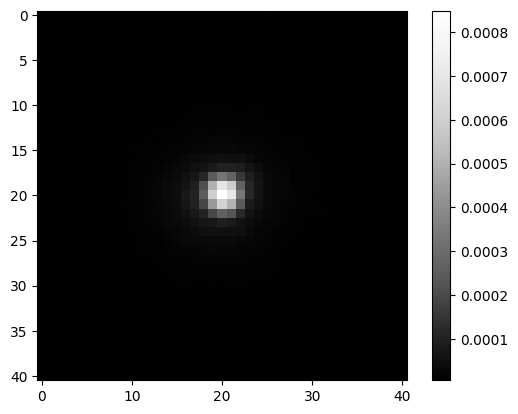

In [10]:
normalized_psf = avg_psf_image / np.sum(avg_psf_image)

imshow(normalized_psf, colorbar=True)

In [11]:
normalized_psf.min(), normalized_psf.max()

(5.601165e-06, 0.0008490512)

In [12]:
imsave('/mnt/disk1/WZH-DataCenter/PROCESS-SPT/MPALM_revision1/SMLM2016_challenge/sequence-as-stack-Beads-2D/psf.tif', normalized_psf)

/tmp/ipykernel_532754/186556448.py:1: UserWarning: /mnt/disk1/WZH-DataCenter/PROCESS-SPT/MPALM_revision1/SMLM2016_challenge/sequence-as-stack-Beads-2D/psf.tif is a low contrast image
  imsave('/mnt/disk1/WZH-DataCenter/PROCESS-SPT/MPALM_revision1/SMLM2016_challenge/sequence-as-stack-Beads-2D/psf.tif', normalized_psf)
